### Alfred the Mail Sorting Butler: A LangGraph Example

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()   # <-- REQUIRED

print(os.getenv("GROQ_API_KEY"))  # should NOT be None

from groq import Groq

client = Groq()   # <-- no need to pass api_key manually


models = client.models.list()
for m in models.data:
    print(m.id)


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
whisper-large-v3-turbo
qwen/qwen3-32b
meta-llama/llama-prompt-guard-2-86m
meta-llama/llama-4-maverick-17b-128e-instruct
canopylabs/orpheus-arabic-saudi
meta-llama/llama-prompt-guard-2-22m
openai/gpt-oss-120b
allam-2-7b
openai/gpt-oss-safeguard-20b
meta-llama/llama-4-scout-17b-16e-instruct
moonshotai/kimi-k2-instruct
openai/gpt-oss-20b
moonshotai/kimi-k2-instruct-0905
llama-3.1-8b-instant
meta-llama/llama-guard-4-12b
groq/compound
groq/compound-mini
llama-3.3-70b-versatile
whisper-large-v3
canopylabs/orpheus-v1-english


In [2]:

# %pip install langchain-openai
# %pip install langchain-groq

import os
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq



from dotenv import load_dotenv
load_dotenv()
 
# Set your OpenAI API key here
import os
# print(os.getenv("OPENAI_API_KEY") is not None)

# model = ChatOpenAI(model="gpt-4o", temperature=0, api_key=os.getenv("OPENAI_API_KEY"))

print(os.getenv("GROQ_API_KEY") is not None)
model = ChatGroq(model= "llama-3.1-8b-instant",
    temperature=0)

/Users/vaishnavirohitkulange/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


# Step 1: Define Our State
## In LangGraph, State is the central concept. It represents all the information that flows through our workflow.

### For Alfred's email processing system, we need to track:

#### The email being processed
#### Whether it's spam or not
#### The draft response (for legitimate emails)
#### Conversation history with the LLM

In [3]:
from typing import TypedDict, Dict, Any, Optional, List

class EmailState(TypedDict):
    email:Dict[str,Any]
    is_spam: Optional[bool]
    spam_reason: Optional[str]
    email_category: Optional[str]
    email_draft: Optional[str]
    messages :List[Dict[str,Any]]
    

## Step 2: Define Our Nodes

In [4]:
def read_email(state: EmailState):
    email = state["email"]
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}

def classify_email(state: EmailState):
    email = state["email"]

    prompt = f""" 
    As alfrerd the butler of Mr wayne and it's SECRET identity Batman, analyze the email and datermine if it is spam or legitimate and should be br
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    First,datermine if this email is spam.
    answer with SPAM or HAM if it's legitimate. Only return the answer
    Answer :
    """
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    response_text= response.content.lower()
    print(response_text)
    is_spam = "spam" in response_text and "ham" not in response_text

    if not is_spam:
        new_messages = state.get("messages", [])+ [
            {"role":"user", "content":prompt},
            {"role": "assistant","content": response.content}
        ]
    else:
        new_messages = state.get("messages",[])
    return {
        "is_spam": is_spam,
        "messages": new_messages
    }

def handle_spam(state : EmailState):
    print(f" Albert has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}

def drafting_response(state: EmailState):
    email = state["email"]

    prompt = f""" As Albert the butler, draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}

    Draft a brief, professional response that Mr.Wayne can review and personalize before sending. 
    """

    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)

    new_messages = state.get("messages",[])+ [
     {"role":"user","content":prompt},
     {"role":"assistant","content": response.content}

    ]

    return {
        "email_draft": response.content,
        "messages": new_messages
    }


def notify_mr_wayne(state: EmailState):
    email = state['email']

    print("\n" + "=" * 50)
    print(f"Sir you've recived an email from {email['sender']}.")
    print(f" Subject: {email['subject']}")
    print("\n I've prepared a deraft response for your review:")
    print("-" * 50)
    print(state["email_draft"])
    print("=" * 50 + "\n")

    return {}



In [5]:
# Define routing logic 
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"
    
    

In [6]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email) #the read_email node executes the read_email function
email_graph.add_node("classify_email", classify_email)  #the classify_email node will excecute the classify_email function
email_graph.add_node("handle_spam",handle_spam) # same logic
email_graph.add_node("drafting_response", drafting_response) # the drafting_response same logic
email_graph.add_node("notify_mr_wayne", notify_mr_wayne) # same logic

## Step 3: Define Our Routing Logic

In [7]:
# Add Edges
email_graph.add_edge(START, "read_email")
email_graph.add_edge("read_email","classify_email")

# Add  conditioning edges
email_graph.add_conditional_edges(
    "classify_email", 
    route_email,
    {
        "spam":"handle_spam",
        "legitimate" : "drafting_response"
    }
 )

#Add final edges 

email_graph.add_edge("handle_spam", END)
email_graph.add_edge("drafting_response", "notify_mr_wayne")
email_graph.add_edge("notify_mr_wayne",END)

## Step 4: Create the StateGraph and Define Edges


In [8]:
# Compiled the graph 
compiled_graph = email_graph.compile()

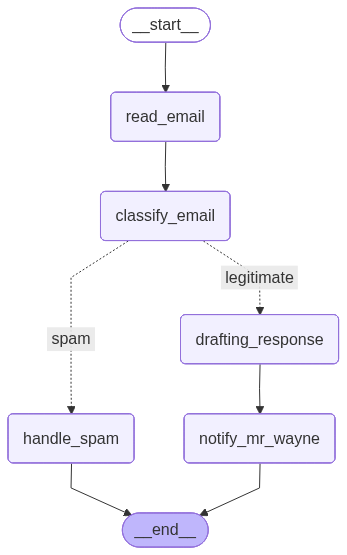

In [9]:
from IPython.display import Image, display
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

## Testing on Example Emails

In [10]:
# Example emails for testing 
legitimate_email = {
    "sender": "Joker",
    "subject": " Found you Batman !",
    "body": "Mr. Wayne,I found your secrete identity ! I know you're batman ! Ther's no denying it, I have proof of that I am comming o find you."
}

spam_email = {
    "sender": "Crypto Bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some !"
}

# Process legitimate email 
print("\n Processing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []

})

#Process spam mail
print("\n Processing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


 Processing legitimate email...
Alfred is processing an email from Joker with subject:  Found you Batman !
spam
 Albert has marked the email as spam.
The email has been moved to the spam folder.

 Processing spam email...
Alfred is processing an email from Crypto Bro with subject: The best investment of 2025
spam
 Albert has marked the email as spam.
The email has been moved to the spam folder.


## Step 5: Inspecting Our Mail Sorting Agent with Langfuse


In [13]:
# Install langfuse if not already installed
%pip install langfuse
%pip install langchain

import os

# Get keys from your project from the project settings page:https://cloud.langfuse.com

from langfuse.langchain import CallbackHandler

langfuse_handler = CallbackHandler()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Authentication error: Langfuse client initialized without public_key. Client will be disabled. Provide a public_key parameter or set LANGFUSE_PUBLIC_KEY environment variable. 


In [14]:
#Process legitimate email
print("\n Processing legitimate email...")
legitimate_result = compiled_graph.invoke(
    input={
        "email": legitimate_email,
        "is_spam": None,
        "drafting_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)

# Process spam email
print("\n Processing spam email...")
spam_result = compiled_graph.invoke(
    input={
        "email": spam_email,
        "is_spam": None,
        "draft_response": None,
        "messages": []
    },
    config={"callbacks": [langfuse_handler]}
)


 Processing legitimate email...
Alfred is processing an email from Joker with subject:  Found you Batman !
spam
 Albert has marked the email as spam.
The email has been moved to the spam folder.

 Processing spam email...
Alfred is processing an email from Crypto Bro with subject: The best investment of 2025
spam
 Albert has marked the email as spam.
The email has been moved to the spam folder.
